# AR/MA processes as as state-space models

In [4]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
from matplotlib.gridspec import GridSpec

In [5]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (7.2, 4.0)


sns.set_palette("colorblind")

In [6]:
def step_ssm(state, key, F, H, T, R):
    theta, noise = state
    # Build next state
    theta = F @ theta + T @ noise
    noise = jax.random.normal(key) * R
    state_next = (theta, noise)
    
    # Build observation 
    y = H @ theta + noise

    out = {
        "y": y,
        "theta": theta
    }
    
    return state_next, out


def run_ssm(key, F, H, T, R, n_steps):
    """
    Run sample of a state-space model
    with initial zero-valued latent process
    """
    dim_latent = F.shape[0]
    theta_init = jnp.zeros((dim_latent, 1))
    noise_init = jnp.eye(1) * 0.0
    state_init = (theta_init, noise_init) # latent and error term

    keys = jax.random.split(key, n_steps)
    step = partial(step_ssm, F=F, H=H, T=T, R=R)
    _, hist = jax.lax.scan(step, state_init, keys)
    hist = jax.tree.map(jnp.squeeze, hist)
    return hist

##  MA(m) process

A time series ${\bf y}_{1:t}$ is said to be a $m$-th order moving average (MA) process
if there are known $p\times p$ matrices ${\bf A}_1, \ldots, {\bf A}_m$ such that
$$
    y_t = \sum_{j=1}^m {\bf A}_{t-j}\,e_j + e_t
$$

In state-space form, the AR(m) process is given by
$$
\begin{aligned}
    \Theta_{t} &= {\bf F}_{\rm MA}\,\Theta_{t-1} + {\bf T}_m\,{\bf e}_{t-1}\\
    {\bf y}_t &= {\bf H}_{\rm MA}\,\Theta_t + {\bf e}_t
\end{aligned}
$$
with
$$
    {\bf F}_\text{MA} =
    \begin{bmatrix}
    {\bf 0} & \ldots & {\bf 0} & {\bf 0}\\
    {\bf I} & \ldots & {\bf 0} & {\bf 0} \\
    {\bf 0} & \ldots & {\bf I} & {\bf 0}
    \end{bmatrix}
$$
and ${\bf u}_t = {\bf T}_m\,{\bf e}_t$ for ${\bf T}_m$ given by
$$
    {\bf T}_m =
    \begin{bmatrix}
    {\bf I}\\
    {\bf 0} \\
    \vdots \\
    {\bf 0}
    \end{bmatrix}
$$

In [63]:
def build_ma_components(H_ma):
    m = len(H_ma.ravel())
    F_ma = jnp.diagflat(jnp.ones(m-1), k=-1)

    Tm = jnp.zeros(m).at[0].set(1)[:, None]
    return F_ma, Tm

### Building blocks

In [64]:
A = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0])[None, :]

F_ma, Tm = build_ma_components(A)

### Sampling

In [65]:
n_steps = 100
key = jax.random.PRNGKey(3141)
R = jnp.eye(1) * 0.1 ** 2 # measurement noise
hist = run_ssm(key, F_ma, A, Tm, R, n_steps)

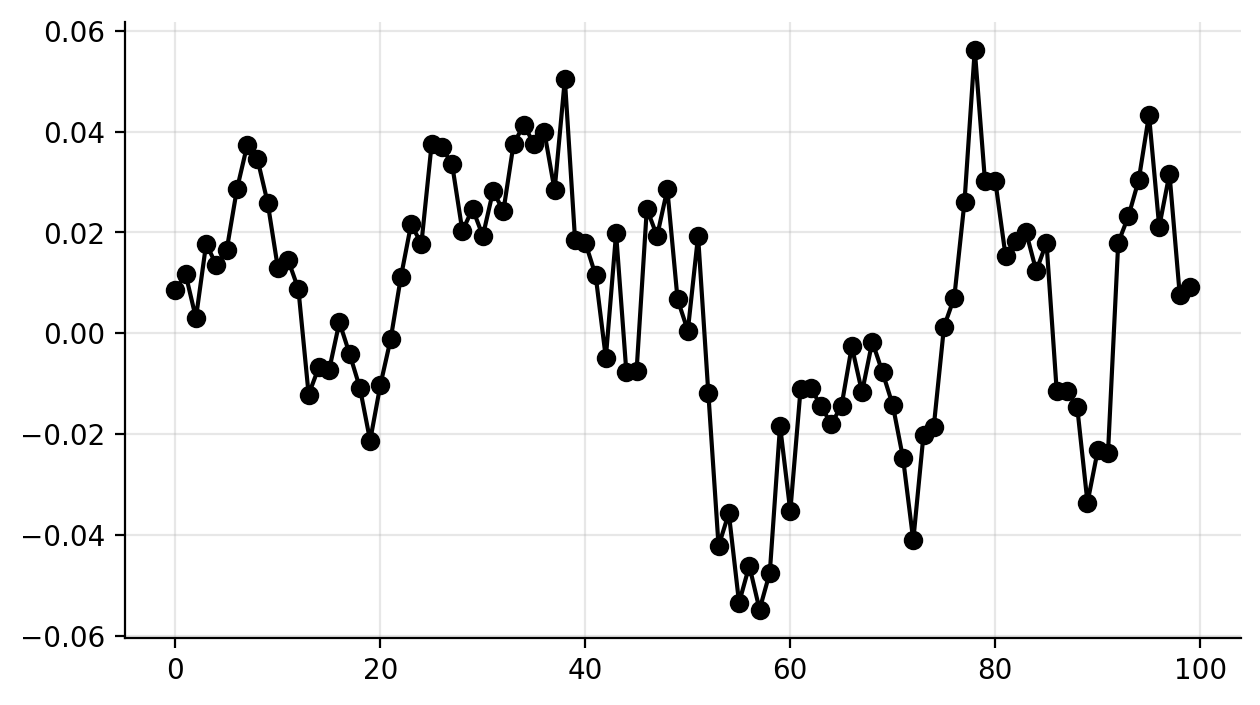

In [66]:
plt.plot(hist["y"], c="black", marker="o")
plt.grid(alpha=0.3)

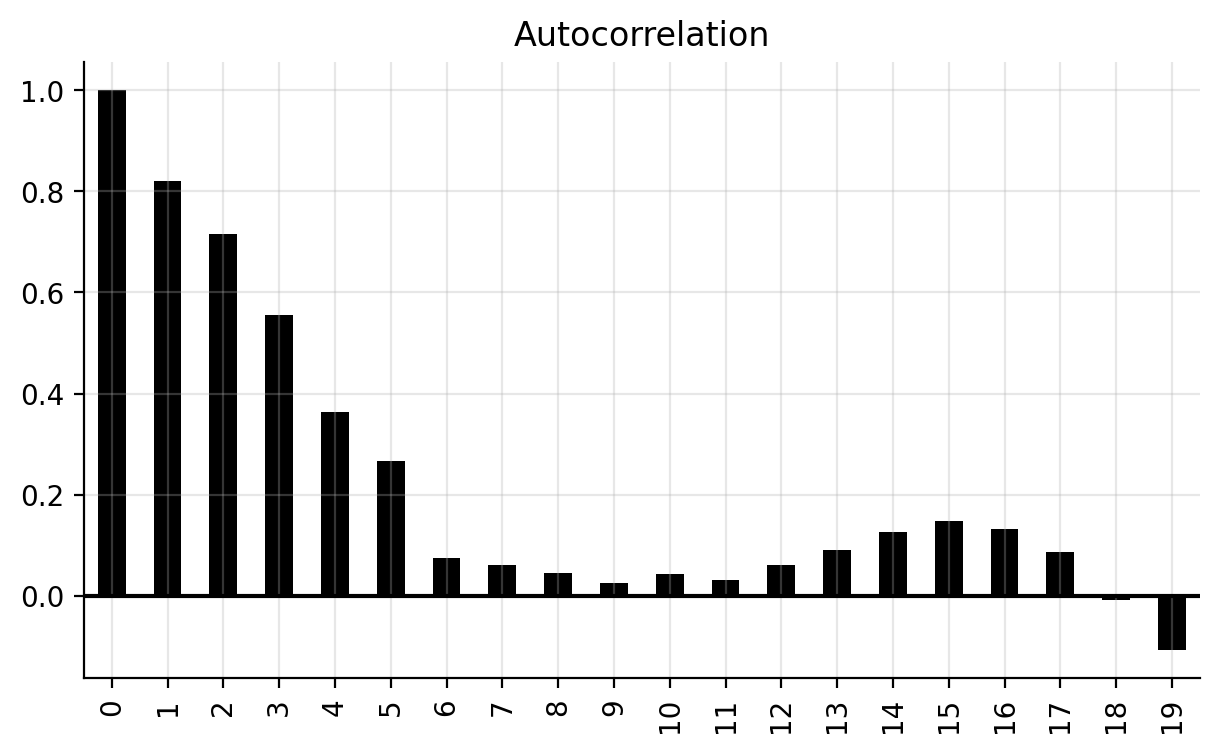

In [67]:
Y = pd.DataFrame(hist["y"])
for i in range(1, 20):
    Y[i] = Y[0].shift(i)
Y.corr()[0].plot(kind="bar", color="black")
plt.title("Autocorrelation")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)

## MA(1) with varying number of parameters

In [68]:
n_values = 10
ma_sims = {}
n_steps = 200
H_ma_values = jnp.linspace(-1, 1, n_values)

for b in H_ma_values:
    H_ma = jnp.array([b])
    F_ma, T_m = build_ma_components(H_ma)
    hist = run_ssm(key, F_ma, H_ma, T_m, R, n_steps)
    ma_sims[float(b)] = hist["y"]
ma_sims = pd.DataFrame(ma_sims)

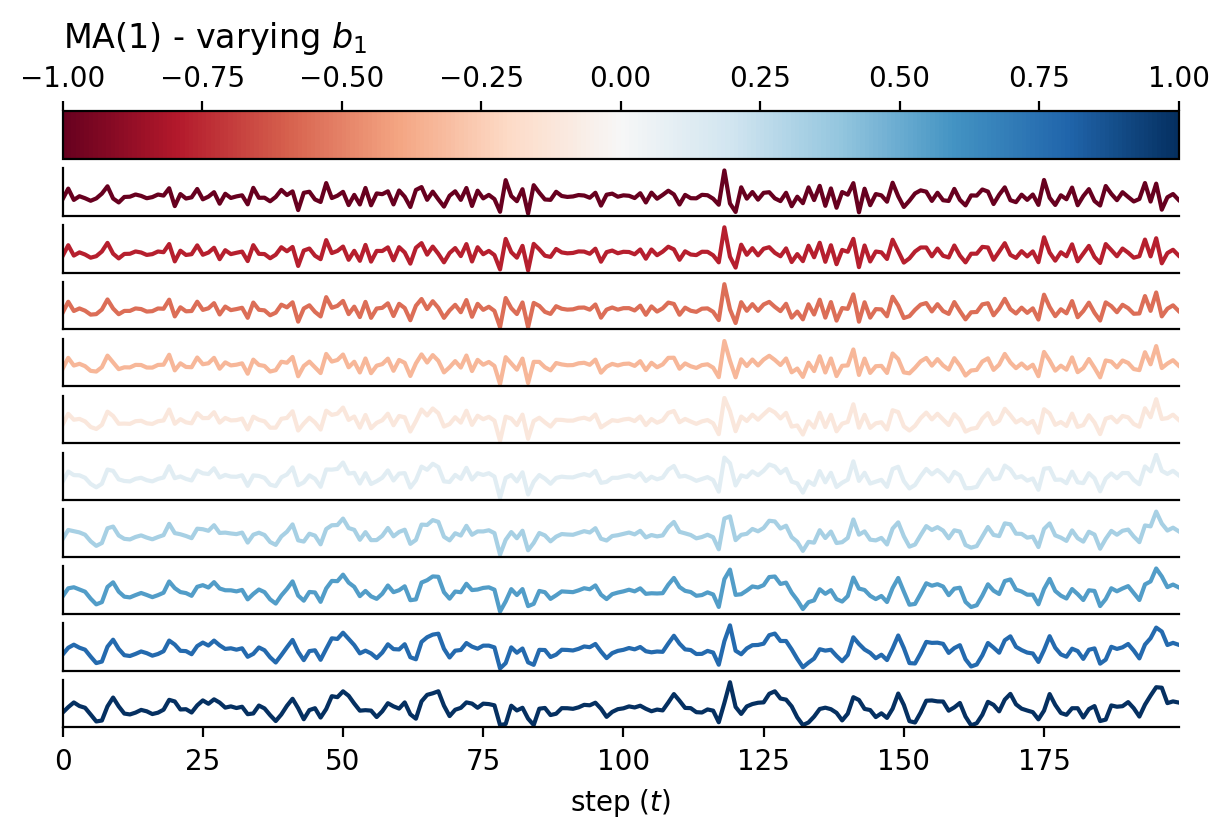

In [69]:
cmap = plt.cm.RdBu
norm = mpl.colors.Normalize(vmin=H_ma_values.min(), vmax=H_ma_values.max())
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
gs = GridSpec(n_values + 1, 1)

ax_cbar = fig.add_subplot(gs[0])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation="horizontal")
ax_cbar.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax_cbar.set_title("MA(1) - varying $b_1$", loc="left")

colors = cmap(jnp.linspace(0, 1, n_values))
for i, (c, b) in enumerate(zip(colors, ma_sims)):
    ax = fig.add_subplot(gs[i+1])
    
    ax.set_yticks([])
    ax.plot(ma_sims[b], c=c)
    ax.set_xlim(0, n_steps-1)
    if i != n_values-1:
        ax.set_xticks([])

ax.set_xlabel("step ($t$)")
plt.savefig("ma1-sample.png", dpi=300, bbox_inches="tight")

In [70]:
lags = np.arange(1, 10)

Text(0.5, 0, 'step ($t$)')

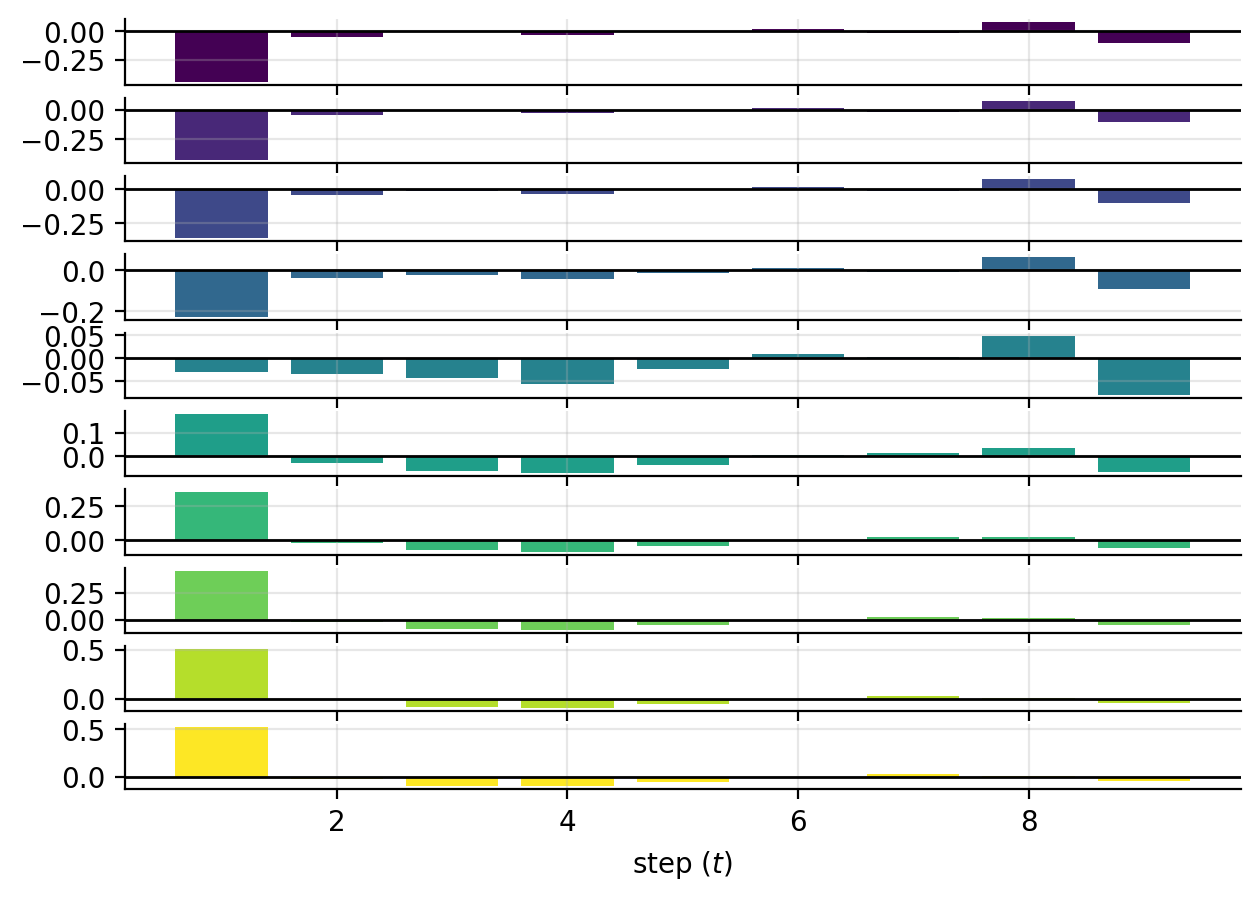

In [71]:
fig, axs = plt.subplots(n_values, 1, sharex=True, figsize=(7.2, 5.0))

colors = plt.cm.viridis(jnp.linspace(0, 1, n_values))
for ax, c, b in zip(axs, colors, ma_sims):
    sim = ma_sims[b]
    autocorrs = [sim.autocorr(lag) for lag in lags]
    ax.bar(lags, autocorrs, color=c, linewidth=2)
    ax.axhline(y=0.0, c="black", linewidth=1)
    
    # ax.set_yticks([])
    # ax.plot(ar_sims[a], c=c)
    ax.grid(alpha=0.3)
ax.set_xlabel("step ($t$)")
# plt.suptitle("AR($1$) with varying $a_1$")

---

## AR(r) process

An $r$th order autoregressive (AR) process has the form
$$
    y_t = \sum_{j=1}^r {\bf B}_j\,y_{t-j} + e_t
$$
with ${\bf B}_1, \ldots, {\bf B}_r$ known coefficient matrices, $e_{1:t}$ zero-mean blockwise uncorrelated random vectors
and $y_{-1} = \ldots = y_{-r} = 0$.

In state-space form, the MA(p) process is given by
$$
\begin{aligned}
    {\bf y}_t &= {\bf H}_{\rm AR}{\bf z}_t + {\bf e}_t\\
    \Theta_{t+1} &= {\bf F}_{\rm AR}{\bf z}_t + {\bf T}_r\,{\bf e}_t
\end{aligned}
$$

with
$$
    {\bf F}_\text{AR} =
    \begin{bmatrix}
    {\bf B}_1 & \ldots & {\bf B}_{r-1} & {\bf B}_r\\
    {\bf I} & \ldots & {\bf 0} & {\bf 0} \\
    {\bf 0} & \ldots & {\bf I} & {\bf 0}
    \end{bmatrix}
$$
and
$$
    {\bf H}_{\rm MA} =
    \begin{bmatrix}
    {\bf B}_1, \ldots, {\bf B}_r
    \end{bmatrix}
$$

In [56]:
def build_ar_components(H_ar):
    r = len(H_ar.ravel())
    F_ar = jnp.diagflat(jnp.ones(r-1), k=-1)
    F_ar = F_ar.at[0].set(H_ar)
    T_r = jnp.zeros(r).at[0].set(1)[:, None]
    return F_ar, T_r

In [57]:
n_steps = 200
key = jax.random.PRNGKey(314)
R = jnp.eye(1) * 0.1 ** 2 # measurement noise

### Sampling

In [58]:
H_ar = jnp.array([1.0, -1.0, 0.3])
F_ar, T_r = build_ar_components(H_ar)
hist = run_ssm(key, F_ar, H_ar, T_r, R, n_steps)

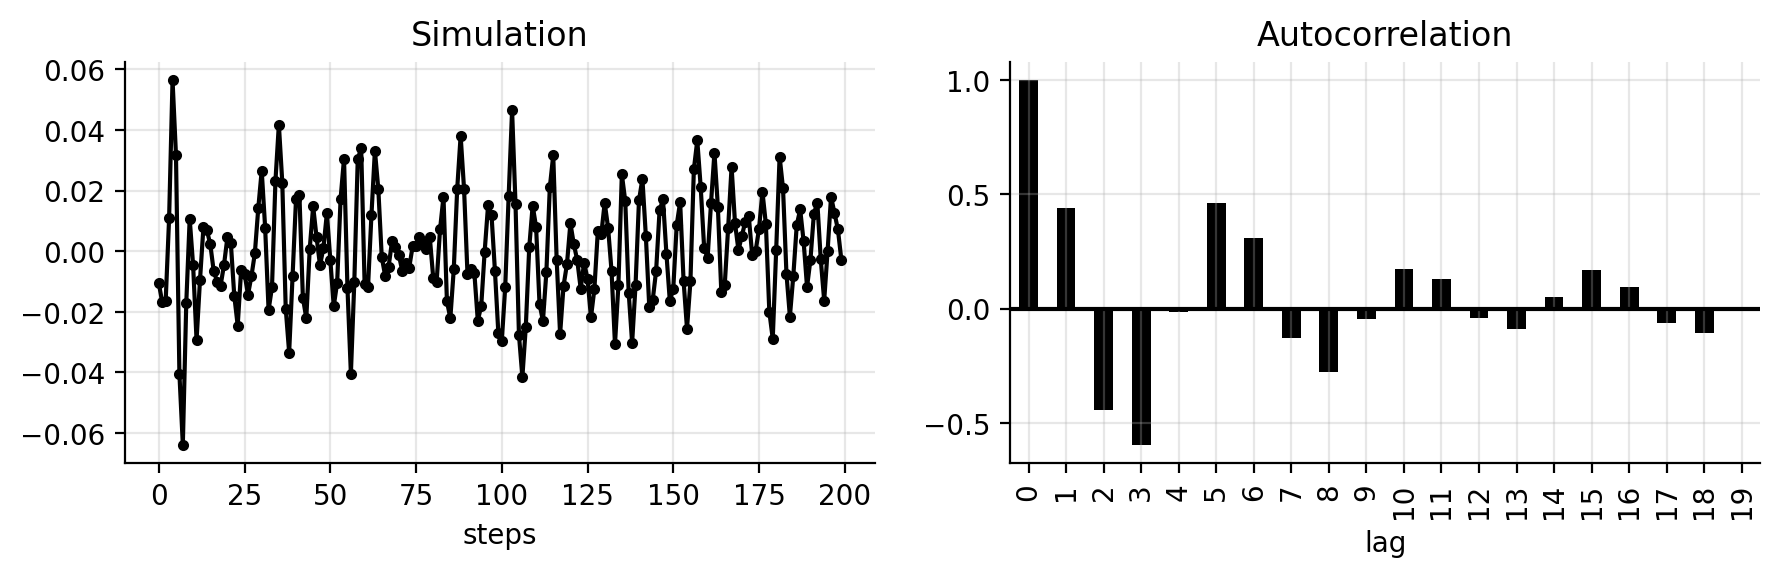

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

ax[0].plot(hist["y"], c="black", marker="o", markersize=3)
ax[0].grid(alpha=0.3)
ax[0].set_title("Simulation")
ax[0].set_xlabel("steps")

Y = pd.DataFrame(hist["y"])
for i in range(1, 20):
    Y[i] = Y[0].shift(i)
Y.corr()[0].plot(kind="bar", color="black", ax=ax[1])
ax[1].axhline(y=0, c="black")
ax[1].set_title("Autocorrelation")
ax[1].set_xlabel("lag")
ax[1].grid(alpha=0.3)
plt.tight_layout()

## AR(1) with varying number of parameters

In [60]:
n_values = 10
ar_sims = {}
n_steps = 200
H_ar_values = jnp.linspace(-1, 1, n_values)

for a in H_ar_values:
    H_ar = jnp.array([a])
    F_ar, T_r = build_ar_components(H_ar)
    hist = run_ssm(key, F_ar, H_ar, T_r, R, n_steps)
    ar_sims[float(a)] = hist["y"]

ar_sims = pd.DataFrame(ar_sims)

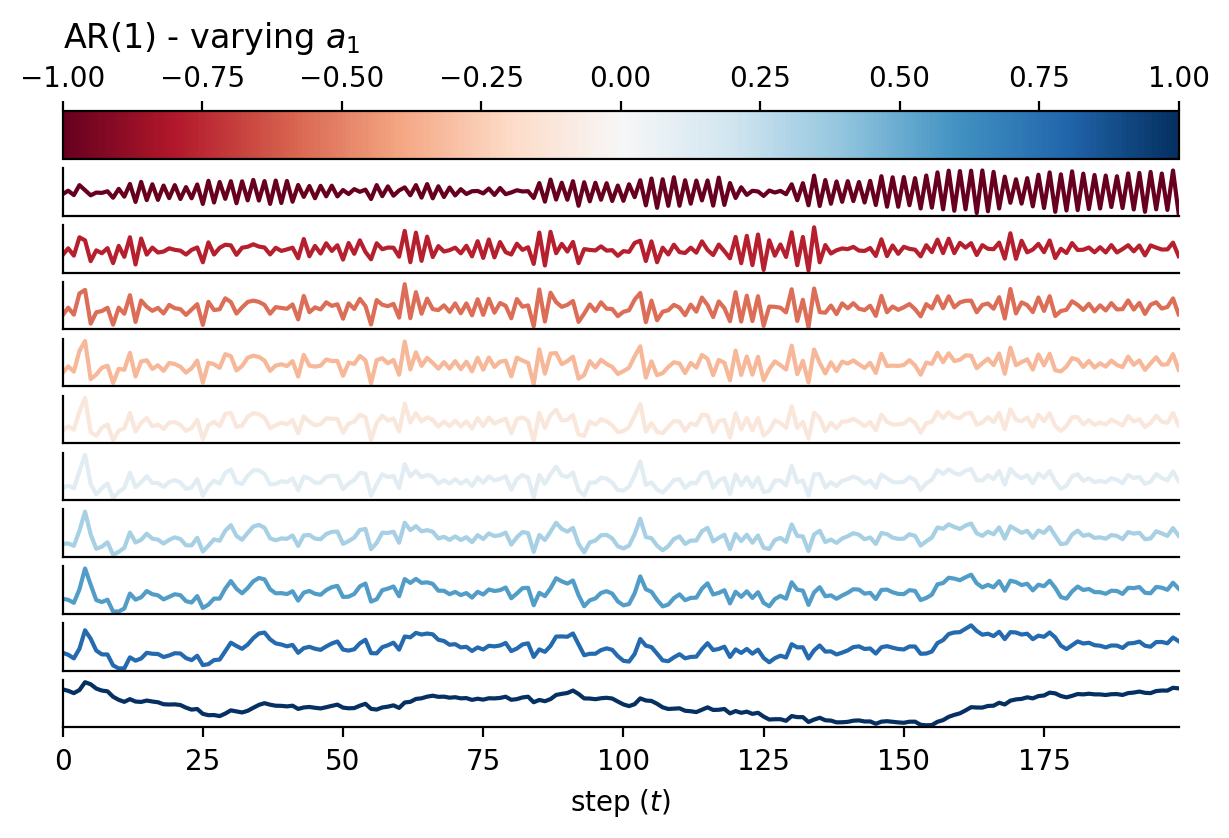

In [61]:

cmap = plt.cm.RdBu
norm = mpl.colors.Normalize(vmin=H_ar_values.min(), vmax=H_ar_values.max())
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
gs = GridSpec(n_values + 1, 1)

ax_cbar = fig.add_subplot(gs[0])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation="horizontal")
ax_cbar.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax_cbar.set_title("AR(1) - varying $a_1$", loc="left")

colors = cmap(jnp.linspace(0, 1, n_values))
for i, (c, a) in enumerate(zip(colors, ar_sims)):
    ax = fig.add_subplot(gs[i+1])
    
    ax.set_yticks([])
    ax.plot(ar_sims[a], c=c)
    ax.set_xlim(0, n_steps-1)
    if i != n_values-1:
        ax.set_xticks([])

ax.set_xlabel("step ($t$)")
plt.savefig("ar1-sample.png", dpi=300, bbox_inches="tight")

## ARMA(r,m) processs

In [16]:
Farma = jnp.zeros((r + m, r + m))
Farma = Farma.at[:r,:r].set(Far)
Farma = Farma.at[r:, r:].set(Fma)

Harma = jnp.c_[B, A]

NameError: name 'r' is not defined

<Axes: >

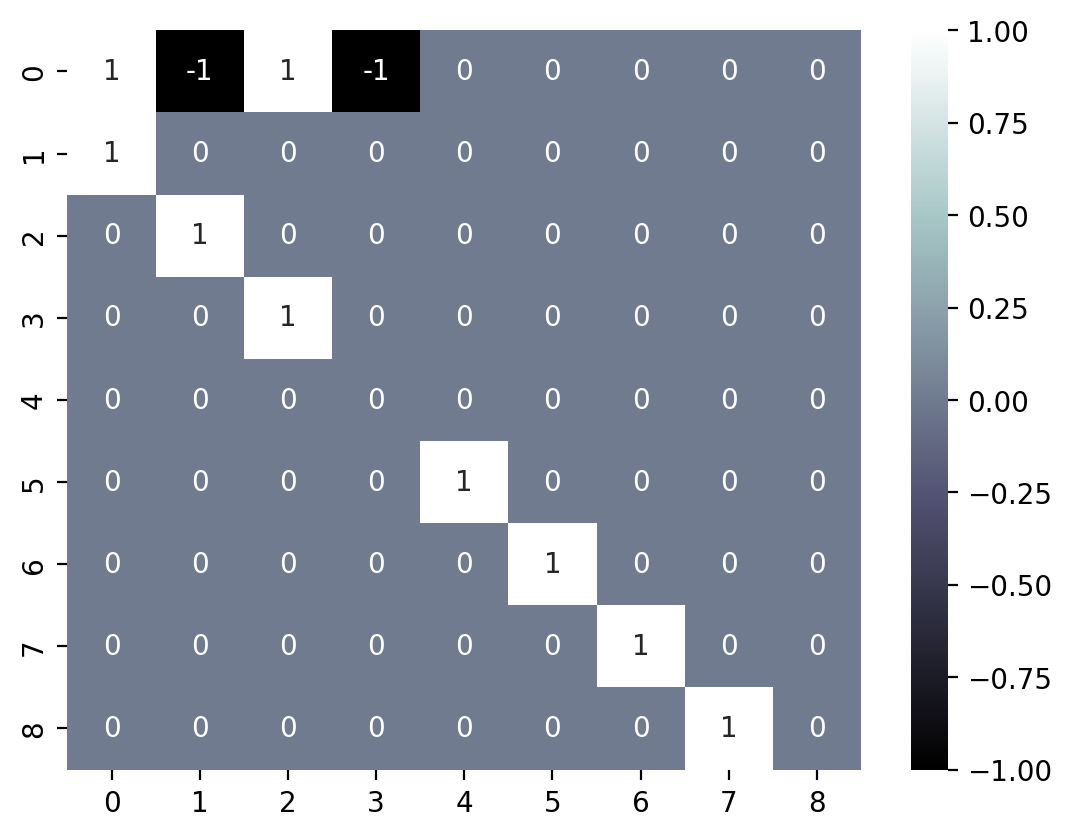

In [20]:
sns.heatmap(Farma, cmap="bone", annot=True)

In [21]:
Trm = jnp.r_[Tr, Tm]

In [22]:
step_arma = partial(step, F=Farma, H=Harma, T=Trm)

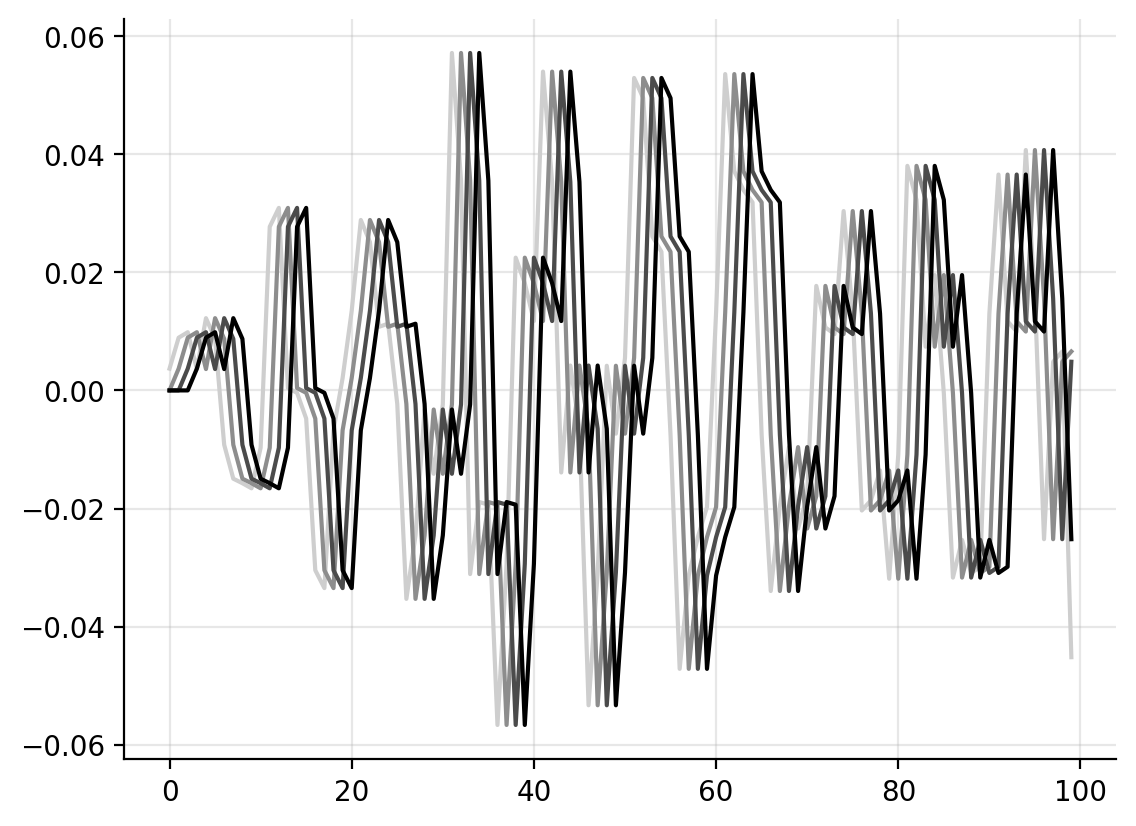

In [23]:
z0 = jnp.zeros((r + m,1))

keys = jax.random.split(key, n_samples)
_, hist = jax.lax.scan(step_arma, z0, keys)
hist = jax.tree.map(jnp.squeeze, hist)

colors = plt.cm.Greys(jnp.linspace(0.3, 1, r))
for i, color in enumerate(colors):
    plt.plot(hist["z"][:, i], color=color)
plt.grid(alpha=0.3)

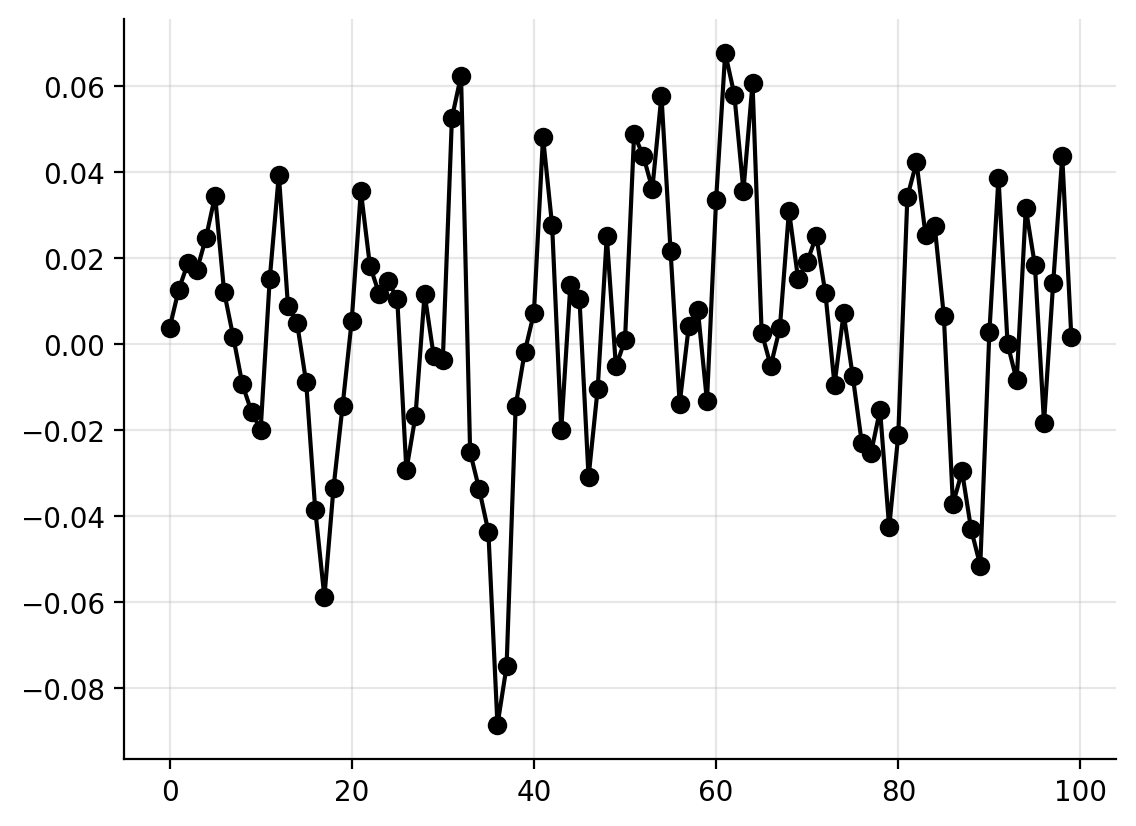

In [24]:
plt.plot(hist["y"], c="black", marker="o")
plt.grid(alpha=0.3)

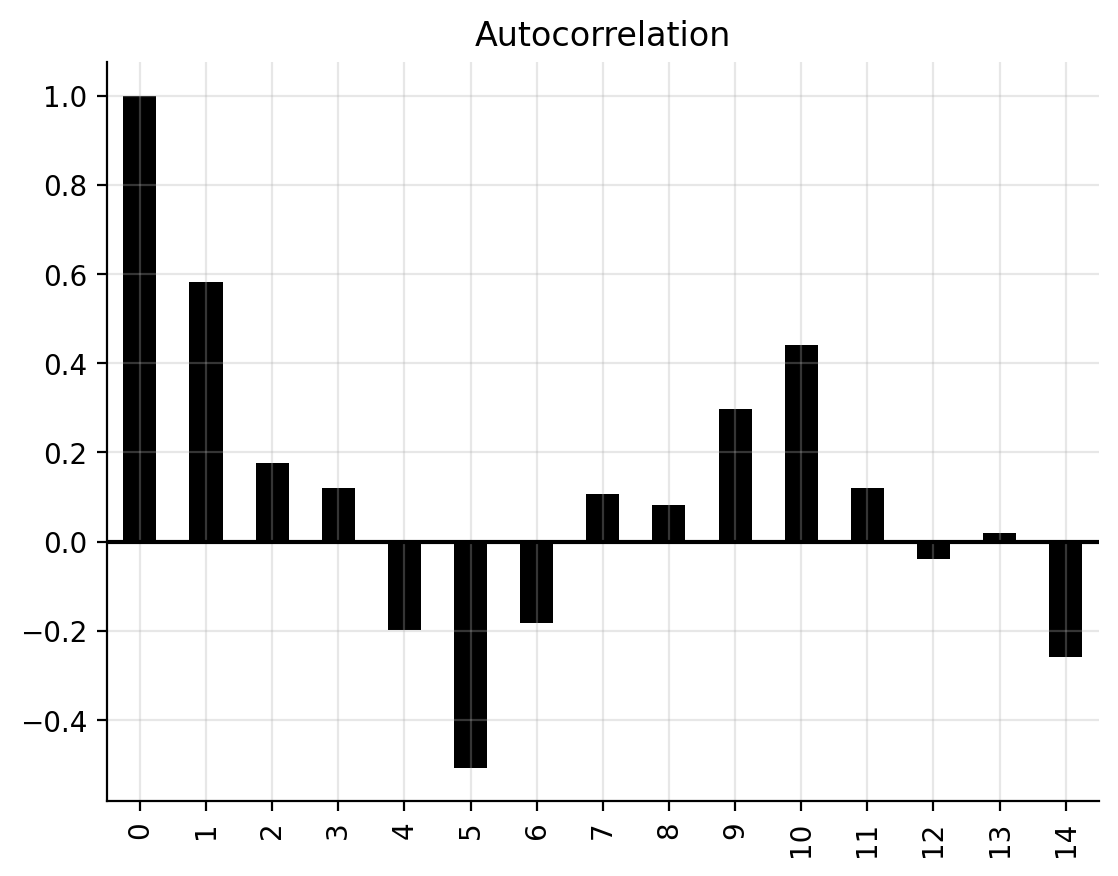

In [25]:
Y = pd.DataFrame(hist["y"])
for i in range(1, 15):
    Y[i] = Y[0].shift(i)
Y.corr()[0].plot(kind="bar", color="black")
plt.axhline(y=0, c="black")
plt.title("Autocorrelation")
plt.grid(alpha=0.3)

##  The fundamental covariance structure
$$
\begin{aligned}
    {\rm Cov}(f_t, \varepsilon_t)
    &= \mathbb{E}\left[(f_t - \bar{f}_t)(\varepsilon_t - \bar{\varepsilon}_t)^\intercal\right]\\
    & \approx \frac{1}{S}\sum_{s=1}^S
    \left(f_t^{(s)} - \bar{f}_t\right)\,
    \left(\varepsilon_t^{(s)} - \bar{\varepsilon_t}\right)^\intercal
\end{aligned}
$$

In [26]:
step_arma = partial(step, F=Farma, H=Harma, T=Trm)

In [33]:
def ssm(key, signal_init, n_steps):
    keys = jax.random.split(key, n_samples)
    _, hist = jax.lax.scan(step_arma, z0, keys)
    hist = jax.tree.map(jnp.squeeze, hist)
    return hist

vssm = jax.vmap(ssm, in_axes=(0, None, None))

In [37]:
z0 = jnp.zeros((r + m,1))
n_sims = 200
keys = jax.random.split(key, n_sims)
hist = vssm(keys, z0, n_samples)

In [39]:
signals = hist["z"]
measurements = hist["y"]

### From measurements to innovations

In [101]:
var_y = jnp.cov(measurements, rowvar=False)

L = jnp.linalg.cholesky(var_y)

# L = L.at[jnp.diag_indices(n_steps)].set(1.0)
R = jnp.diag(L)
L = jnp.einsum("ij,j->ij", L, 1 / R)


assert jnp.diag(var_y).sum() == jnp.diag(jnp.einsum("ij,j,jk->ik", L, R ** 2, L.T)).sum()

innovations = jnp.linalg.solve(L, measurements.T).T[..., None]

In [102]:
innovations.shape

(200, 100, 1)

In [103]:
signals.shape

(200, 100, 9)

In [263]:
t = 0
jnp.cov(signals[:, t, :], innovations[:, t, :], rowvar=False)[:-1, -1]

Array([0.00012, 0.     , 0.     , 0.     , 0.00012, 0.     , 0.     , 0.     , 0.     ], dtype=float32)

In [264]:
@partial(jax.vmap, in_axes=(1, None), out_axes=0)
@partial(jax.vmap, in_axes=(None, 1), out_axes=0)
def block_covariance(signals, innovations):
    return jnp.cov(signals, innovations, rowvar=False)[:-1, -1]

### The fundamental covariance matrix
$$
    \Sigma = \{{\rm Cov}(f_t, \varepsilon_j)\}_{t,j=1}^T
$$

In [265]:
C = block_covariance(signals, innovations)
C.shape

(100, 100, 9)

In [292]:
Cnorm = (C - C.min()) / (C.max() - C.min())

In [293]:
C.shape

(100, 100, 9)

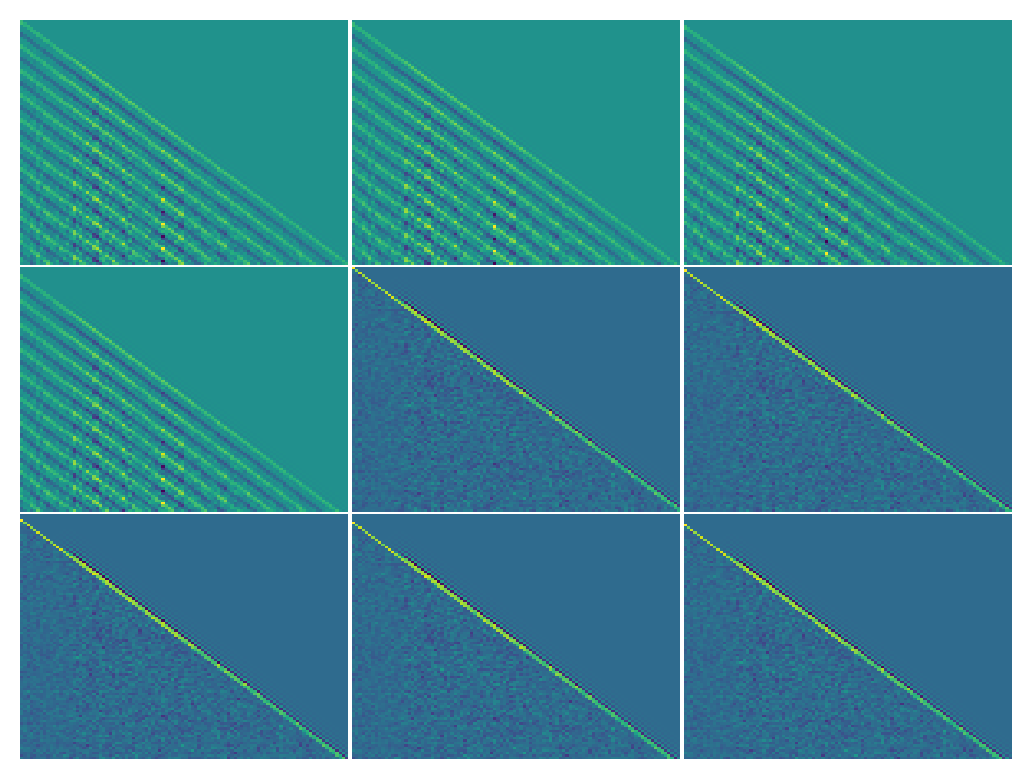

In [296]:
fig, axs = plt.subplots(3, 3)
vmin, vmax = C.min(), C.max()
for n, ax in enumerate(axs.ravel()):
    sns.heatmap(C[..., n], cmap="viridis", cbar=False, ax=ax)
    ax.axis("off")
fig.subplots_adjust(wspace=0.01, hspace=0.01)

<Axes: >

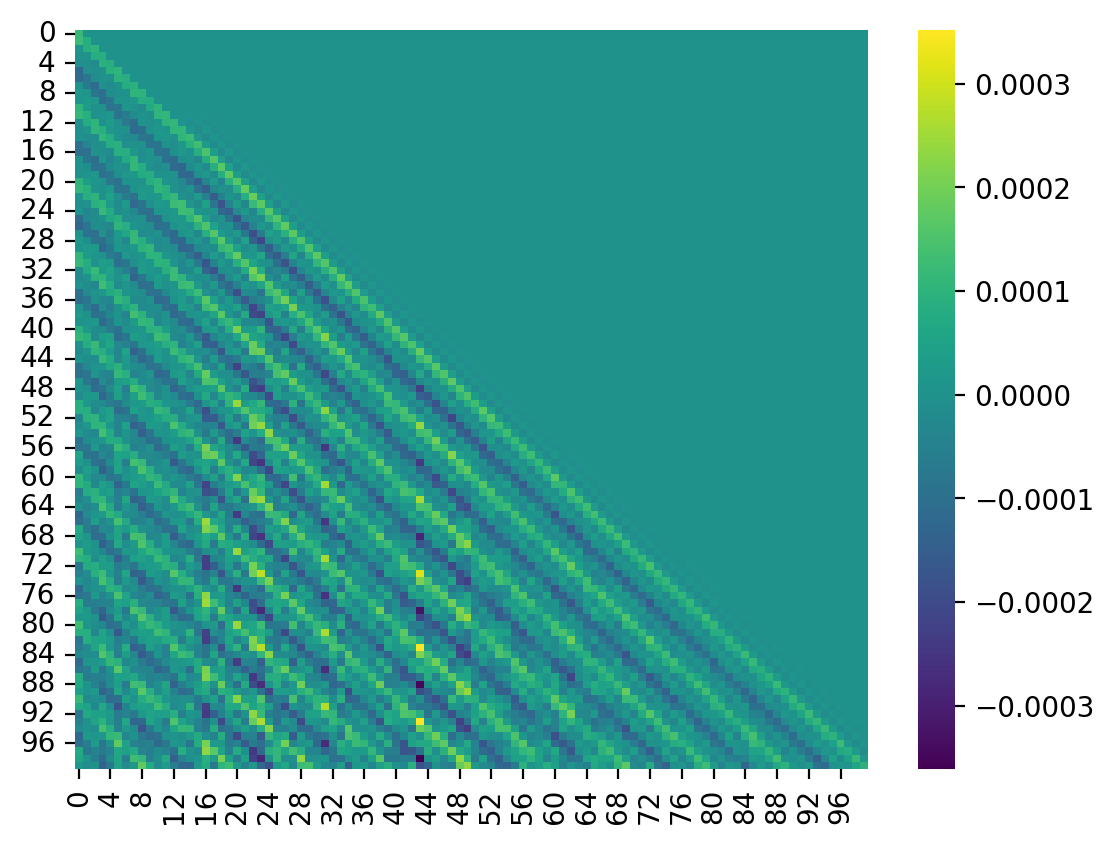

In [297]:
sns.heatmap(C[..., 0], cmap="viridis")

In [249]:
import numpy as np
from matplotlib.animation import FuncAnimation

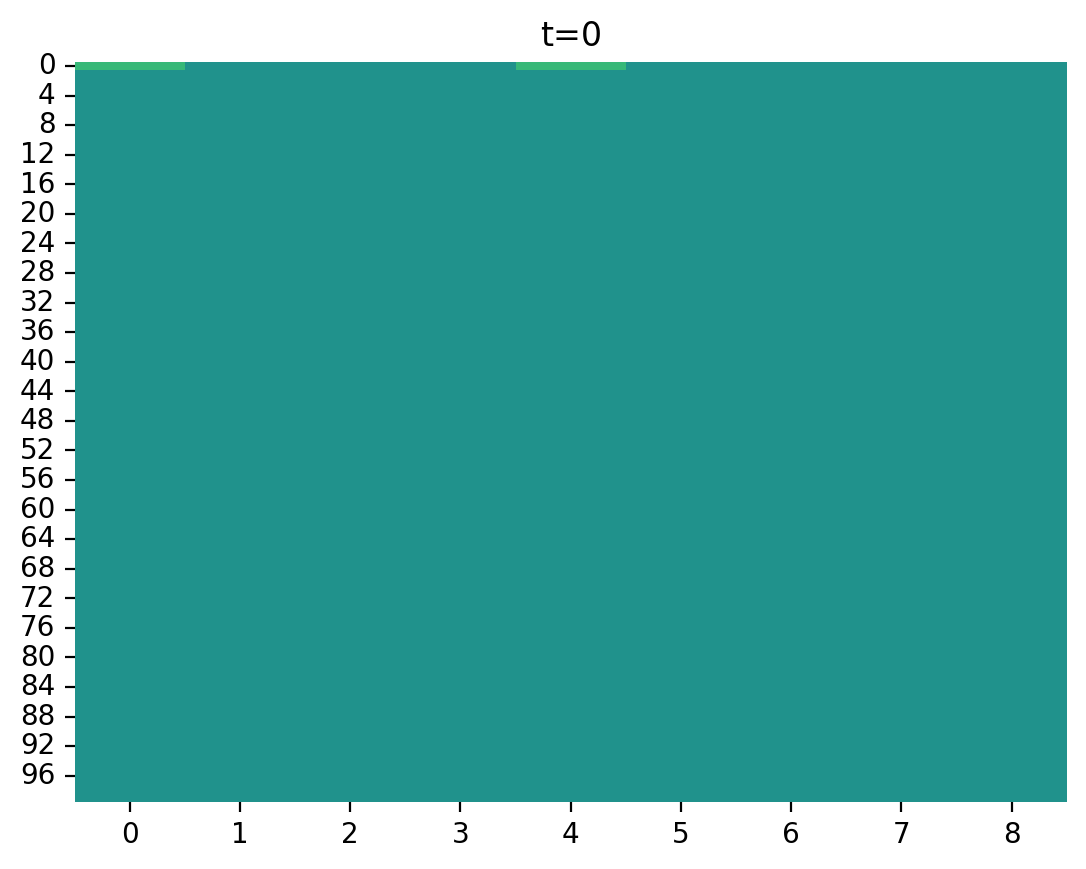

In [250]:
fig, ax = plt.subplots()
def animate(t):
    print(f"{t=}", end="\r")
    ax.cla()
    sns.heatmap(C[t, :, :], cmap="viridis", cbar=False, vmax=C.max(), vmin=C.min())
    ax.set_title(f"{t=}")
anim = FuncAnimation(fig, animate, frames=np.arange(100))
anim.save("animation.gif")